## https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/blazingtext_word2vec_text8/blazingtext_word2vec_text8.ipynb

In [1]:
arabic_text = '''المعلمة,مرحباً يا أطفال، ماذا تحبون أن تأكلوا للغداء؟'
الطالب 1,أنا أحب البيتزا!
المعلمة,جيد، وأنت يا سارة؟
سارة,أنا أحب الأرز والدجاج.
المعلمة,هل تحبون الفواكه؟
الطالب 2,نعم، أحب التفاح.
المعلمة,وأنا أحب الموز. الفواكه صحية لنا.'''

In [2]:
arabic_text

"المعلمة,مرحباً يا أطفال، ماذا تحبون أن تأكلوا للغداء؟'\nالطالب 1,أنا أحب البيتزا!\nالمعلمة,جيد، وأنت يا سارة؟\nسارة,أنا أحب الأرز والدجاج.\nالمعلمة,هل تحبون الفواكه؟\nالطالب 2,نعم، أحب التفاح.\nالمعلمة,وأنا أحب الموز. الفواكه صحية لنا."

In [1]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
aws_role = get_execution_role()


sm_role = sagemaker.get_execution_role()

aws_region = boto3.Session().region_name
sm_session = sagemaker.Session()

print(f"Using Role: {sm_role}")
s3_bucket = sm_session.default_bucket()
s3_bucket

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using Role: arn:aws:iam::287758680514:role/service-role/AmazonSageMaker-ExecutionRole-20231027T004238


'sagemaker-us-east-1-287758680514'

In [3]:
s3_bucket

'sagemaker-us-east-1-287758680514'

In [7]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(aws_region, "blazingtext", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [8]:
print(f"Using SageMaker BlazingText container: {container} ({aws_region})")

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


In [9]:
!ls -al

total 97696
drwxrwxr-x 3 ec2-user ec2-user      4096 Nov 27 02:12 .
drwxrwxr-x 6 ec2-user ec2-user      4096 Nov 25 21:37 ..
drwxrwxr-x 2 ec2-user ec2-user      4096 Nov 25 21:37 .ipynb_checkpoints
-rw-rw-r-- 1 ec2-user ec2-user 100000000 Nov 25 21:36 text8
-rw-rw-r-- 1 ec2-user ec2-user     21524 Nov 27 02:12 trainArabicVectors.ipynb


In [26]:
s3_client = boto3.client("s3")

# data_bucket = (
#     f"sagemaker-example-files-prod-{aws_region}"  # Replace with the bucket where your data is located
# )
# data_prefix = "datasets/text/text8/text8"

output_bucket = s3_bucket
output_prefix = "blazingText"
# s3_client.download_file(data_bucket, data_prefix, "text8")
# s3_client.upload_file("./text8", output_bucket, output_prefix + "/arabic-train")

s3_train_data = f"s3://{output_bucket}/{output_prefix}/quran-simple.txt"

In [27]:
s3_train_data

's3://sagemaker-us-east-1-287758680514/blazingText/quran-simple.txt'

In [28]:
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

In [29]:
bt_model = sagemaker.estimator.Estimator(
    container,
    aws_role,
    instance_count=2,
    instance_type="ml.c4.2xlarge",
    train_volume_size=5,
    train_max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sm_session,
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [30]:
bt_model

In [31]:
bt_model.set_hyperparameters(
    mode="batch_skipgram",
    epochs=5,
    min_count=5,
    sampling_threshold=0.0001,
    learning_rate=0.05,
    window_size=5,
    vector_dim=100,
    negative_samples=5,
    batch_size=11,  #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
    evaluation=True,  # Perform similarity evaluation on WS-353 dataset at the end of training
    subwords=False,
)  # Subword embedding learning is not supported by batch_skipgram

In [32]:
train_data = sagemaker.session.s3_input(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data}

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [33]:
train_data

<sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7f06a5d54f70>

In [34]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2023-11-28-03-07-39-738


2023-11-28 03:07:39 Starting - Starting the training job......
2023-11-28 03:08:15 Starting - Preparing the instances for training......
2023-11-28 03:09:40 Downloading - Downloading input data......
2023-11-28 03:10:16 Training - Training image download completed. Training in progress.Arguments: train
Found 10.2.229.212 for host algo-1
Found 10.2.230.224 for host algo-2
Arguments: train
Found 10.2.229.212 for host algo-1
Found 10.2.230.224 for host algo-2
/opt/amazon/lib/python3.8/site-packages/blazingtext/train_methods.py:176: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if p.poll() is not 0:
/opt/amazon/lib/python3.8/site-packages/blazingtext/train_methods.py:253: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if p.poll() is not 0:
/opt/amazon/lib/python3.8/site-packages/blazingtext/train_methods.py:326: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if p.poll() is not 0:
[11/28/2023 03:10:37 WARNING 139972850710336] Loggers have already b

In [35]:
bt_endpoint = bt_model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")


INFO:sagemaker:Creating model with name: blazingtext-2023-11-28-03-12-20-764
INFO:sagemaker:Creating endpoint-config with name blazingtext-2023-11-28-03-12-20-764
INFO:sagemaker:Creating endpoint with name blazingtext-2023-11-28-03-12-20-764


------!

In [36]:
words = ["إِبِل", "جَمَل", "بَعِير", "ناقة"]

payload = {"instances": words}

response = bt_endpoint.predict(
    json.dumps(payload),
    initial_args={"ContentType": "application/json", "Accept": "application/json"},
)

vecs = json.loads(response)
print(vecs)

[{'vector': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'word': 'إِبِل'}, {'vector': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [21]:
len(vecs)

2

In [27]:
len(vecs[0])

2

In [33]:
len(vecs[0]['vector'])

100

In [17]:
bt_model.model_data

's3://sagemaker-us-east-1-287758680514/blazingText/output/blazingtext-2023-11-28-02-44-33-779/output/model.tar.gz'

In [37]:
s3 = boto3.resource("s3")

key = bt_model.model_data[bt_model.model_data.find("/", 5) + 1 :]
s3.Bucket(output_bucket).download_file(key, "arabic-model.tar.gz")

In [38]:
!mkdir arabic

In [39]:
!ls

arabic		     model.tar.gz		 trainArabicVectors.ipynb
arabic-model.tar.gz  text8			 vectors.bin
eval.json	     trainArabicVectors-2.ipynb  vectors.txt


In [40]:
!tar -xvzf arabic-model.tar.gz --directory arabic

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
eval.json
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
vectors.bin
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
vectors.txt


In [41]:
!ls arabic

eval.json  vectors.bin	vectors.txt


In [42]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
with open("arabic/vectors.txt", "r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num - 1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [43]:
word_vecs

array([[ 0.06823892,  0.0399881 , -0.02905441, ...,  0.13611613,
        -0.0143258 , -0.01706949],
       [-0.00671766,  0.01377701, -0.04085285, ...,  0.04810068,
        -0.06418637, -0.05816791],
       [ 0.03965578,  0.08124973, -0.01156743, ...,  0.16451489,
        -0.03813596, -0.01649749],
       ...,
       [ 0.08060248,  0.03558905, -0.0255944 , ...,  0.13449643,
        -0.06464961, -0.03119546],
       [ 0.11177909,  0.05945168, -0.08672903, ...,  0.08364612,
        -0.00544613, -0.07543508],
       [-0.05350462, -0.08736895, -0.03741177, ...,  0.05630937,
        -0.06681921, -0.07559585]])

In [44]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init="pca", n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

In [50]:
output_bucket, output_prefix

('sagemaker-us-east-1-287758680514', 'blazingText')

In [54]:
# data_bucket = (
#     f"{output_bucket}"  # Replace with the bucket where your data is located
# )
font_prefix = "blazingText/DroidKufi-Regular.ttf"

s3_client.download_file(output_bucket, font_prefix, "DroidKufi-Regular.ttf")

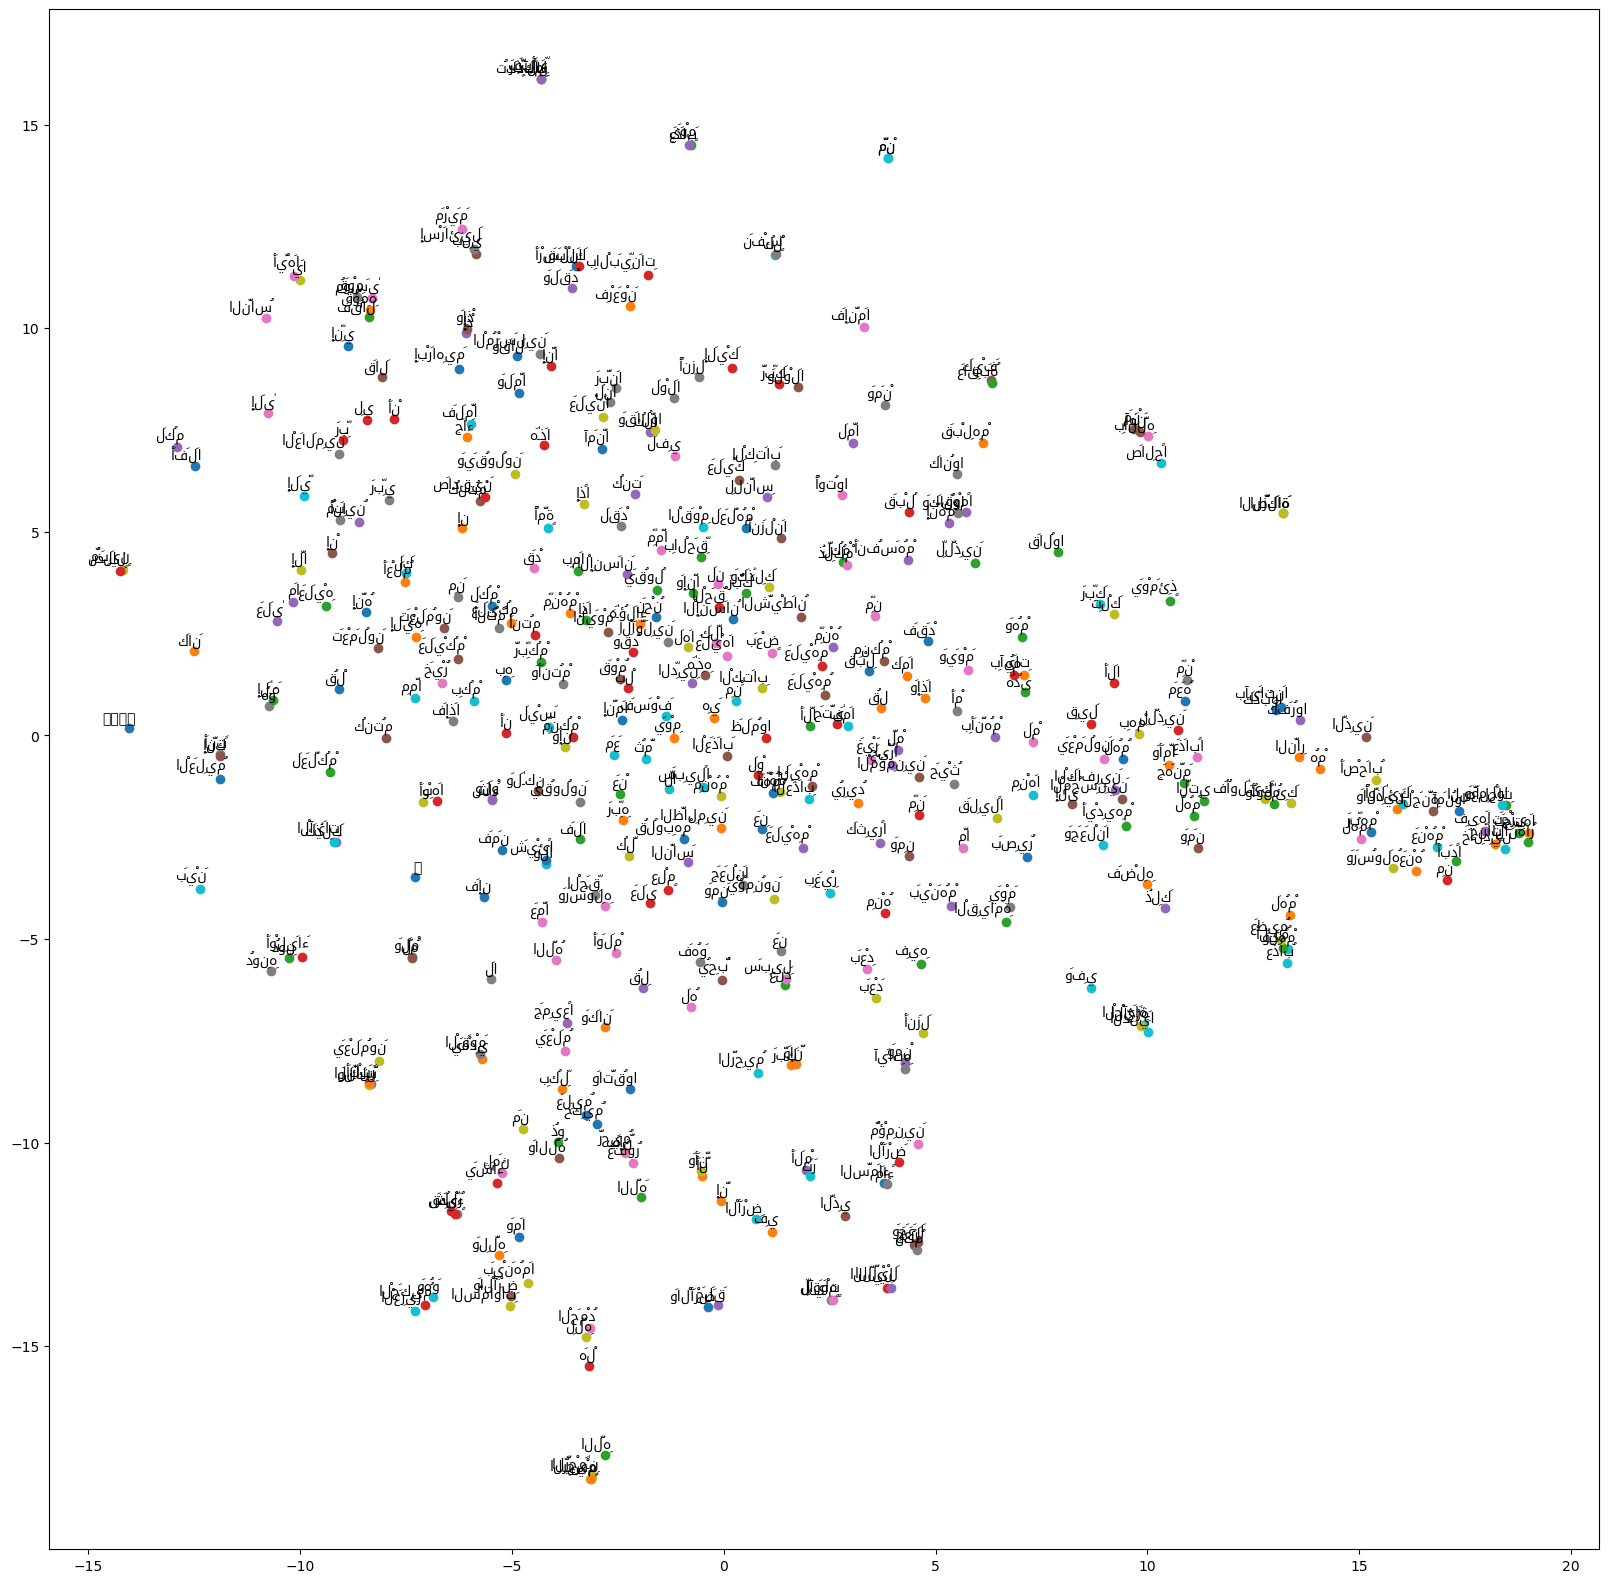

In [56]:
from matplotlib import pylab

%matplotlib inline

import matplotlib.font_manager as fm

# Use a font that supports Arabic characters
prop = fm.FontProperties(fname='./DroidKufi-Regular.ttf')  # Specify the correct path to the font file


def plot(embeddings, labels):
    pylab.figure(figsize=(20, 20))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(
            label, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom", font_properties=prop
        )
    pylab.show()


plot(two_d_embeddings, labels)

In [49]:
# sm_session.delete_endpoint(bt_endpoint.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: blazingtext-2023-11-27-04-02-32-286
